In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble
import lime.lime_tabular


### Load iris dataset

In [2]:
iris_dataset = pd.read_csv(
    "../data/iris-classification/iris.data",
    names=[
        "sepal_length",
        "sepal_width",
        "petal_length",
        "petal_width",
        "label"
    ]).sample(frac=1)
iris_dataset

,sepal_length,sepal_width,petal_length,petal_width,label
59,5.2,2.7,3.9,1.4,Iris-versicolor
91,6.1,3.0,4.6,1.4,Iris-versicolor
108,6.7,2.5,5.8,1.8,Iris-virginica
129,7.2,3.0,5.8,1.6,Iris-virginica
99,5.7,2.8,4.1,1.3,Iris-versicolor
...,...,...,...,...,...
37,4.9,3.1,1.5,0.1,Iris-setosa
22,4.6,3.6,1.0,0.2,Iris-setosa
52,6.9,3.1,4.9,1.5,Iris-versicolor
125,7.2,3.2,6.0,1.8,Iris-virginica


In [3]:
iris_dataset.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [4]:
iris_dataset.corr()

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.109369,0.871754,0.817954
sepal_width,-0.109369,1.000000,-0.420516,-0.356544
petal_length,0.871754,-0.420516,1.000000,0.962757
petal_width,0.817954,-0.356544,0.962757,1.000000


In [5]:
# encoder = OneHotEncoder(sparse=False)
# categories_transformed = encoder.fit_transform(iris_dataset[["label"]])
# encoder.categories_[0]

In [6]:
iris_dataset_transformed_labels = iris_dataset.copy()
iris_dataset_transformed_labels["iris_setosa"] = iris_dataset_transformed_labels["label"] == "Iris-setosa"
iris_dataset_transformed_labels["iris_versicolor"] = iris_dataset_transformed_labels["label"] == "Iris-versicolor"
iris_dataset_transformed_labels["iris_virginica"] = iris_dataset_transformed_labels["label"] == "Iris-virginica"
iris_dataset_transformed_labels.corr()

,sepal_length,sepal_width,petal_length,petal_width,iris_setosa,iris_versicolor,iris_virginica
sepal_length,1.000000,-0.109369,0.871754,0.817954,-0.717416,0.079396,0.638020
sepal_width,-0.109369,1.000000,-0.420516,-0.356544,0.595601,-0.464700,-0.130901
petal_length,0.871754,-0.420516,1.000000,0.962757,-0.922688,0.201587,0.721102
petal_width,0.817954,-0.356544,0.962757,1.000000,-0.887510,0.118376,0.769134
iris_setosa,-0.717416,0.595601,-0.922688,-0.887510,1.000000,-0.500000,-0.500000
iris_versicolor,0.079396,-0.464700,0.201587,0.118376,-0.500000,1.000000,-0.500000
iris_virginica,0.638020,-0.130901,0.721102,0.769134,-0.500000,-0.500000,1.000000


### Prepare dataset 

In [7]:
labels_column_name = "label"
train_set = iris_dataset.drop(columns=labels_column_name).values
train_labels = iris_dataset[labels_column_name].values
jackknife_idx = np.random.randint(0, train_set.shape[0])
test_set = train_set[[jackknife_idx], :]
test_labels = train_labels[[jackknife_idx]]


unique_labels = np.unique(train_labels)
attributes = iris_dataset.columns.tolist()
attributes.remove(labels_column_name)
unique_labels.sort()
attributes.sort()
print(f"Labels: {unique_labels}")
print(f"Attributes: {attributes}")

Labels: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']
Attributes: ['petal_length', 'petal_width', 'sepal_length', 'sepal_width']


In [8]:
random_forest = sklearn.ensemble.RandomForestClassifier(n_estimators = 42)
random_forest.fit(train_set, train_labels)

RandomForestClassifier(n_estimators=42)

In [9]:
result = random_forest.predict(test_set)
accuracy = sklearn.metrics.accuracy_score(test_labels, result)
print(f"Predicted: {result}. It's accuracy: {accuracy}")

Predicted: ['Iris-versicolor']. It's accuracy: 1.0


### Use LIME to explain local prediction

In [10]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    train_set,
    feature_names = attributes,
    class_names = train_labels
)

Show probabilities for random instance (given by random forest on test dataset)

In [11]:
instance = test_set[0]
probabilities = random_forest.predict_proba(instance.reshape(1,-1))[0,:]
probabilities_for_labels = {}
for label, probability in zip(random_forest.classes_, probabilities):
    probabilities_for_labels[label] = probability
print(probabilities_for_labels)
predicted_label_id = np.argmax(probabilities)

{'Iris-setosa': 0.0, 'Iris-versicolor': 1.0, 'Iris-virginica': 0.0}


Explain the instance

array([0., 1., 0.])

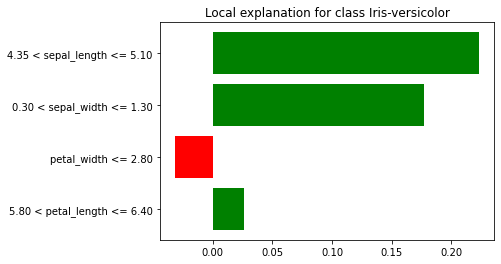

In [12]:
exp = explainer.explain_instance(
    instance,
    random_forest.predict_proba,
    num_features = 4,
    top_labels = 3
)
exp.as_pyplot_figure(predicted_label_id)
exp.predict_proba

Update some attributes to see if probabilities would change

In [13]:
most_important_feature_id = exp.as_map()[predicted_label_id][0][0]
exp.as_list(predicted_label_id)


[('4.35 < sepal_length <= 5.10', 0.22323523733089304),
 ('0.30 < sepal_width <= 1.30', 0.1769453831946335),
 ('petal_width <= 2.80', -0.03171686063470365),
 ('5.80 < petal_length <= 6.40', 0.02583719714608582)]

In [14]:
instance

array([6.3, 2.3, 4.4, 1.3])

In [15]:
instance_to_experiment_with = instance.copy()
print('Probabilities before:', random_forest.predict_proba(instance_to_experiment_with.reshape(1,-1)))
instance_to_experiment_with[most_important_feature_id] = 2.0
print('Probabilities after:', random_forest.predict_proba(instance_to_experiment_with.reshape(1,-1)))

Probabilities before: [[0. 1. 0.]]
Probabilities after: [[0.52380952 0.47619048 0.        ]]


Explain changed instance to see the changes

In [16]:
explainer.discretizer.bins_map  # TODO need to modify src to get suggested change

[array([5.1, 5.8, 6.4]),
 array([2.8, 3. , 3.3]),
 array([1.6 , 4.35, 5.1 ]),
 array([0.3, 1.3, 1.8])]

array([0.52380952, 0.47619048, 0.        ])

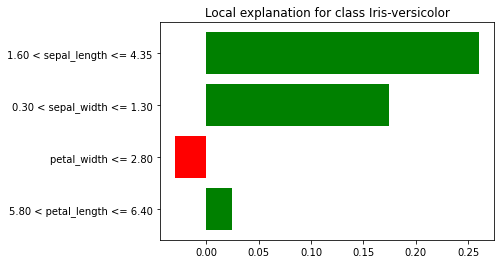

In [17]:
exp = explainer.explain_instance(
    instance_to_experiment_with,
    random_forest.predict_proba,
    num_features = 4,
    top_labels = 3
)
exp.as_pyplot_figure(predicted_label_id)
exp.predict_proba